<a href="https://colab.research.google.com/github/olufam/Msc-Dissertation/blob/main/Safety_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>⭕ Safety Compliance in Work Environments: </br> ▶ &nbsp; An Image and Facial Detection System Using Machine Learning</b></h2>
<hr>
<h3><b>🦸 &nbsp; Author :</b> Olumide Famuyiwa
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;
<b>🦸 &nbsp; Supervisor :</b> Olumide Famuyiwa</h3>
<hr>

## [Introduction](#intro)

## Table of Contents
1. [Installing Required Packages](#installing-required-packages)
2. [Importing Libraries](#importing-libraries)
3. [Performing Extra Setup](#performing-extra-setup)
4. [Dataset for Object Detection](#dataset-for-object-detection)
5. [Data Analysis for Object Detection](#data-analysis-for-object-detection)
6. [Training Object Detection Model (YOLOv8)](#training-object-detection-model)
7. [Evaluating Object Detection Model](#evaluating-object-detection-model)
8. [Testing Object Detection Model](#testing-object-detection-model)
9. [Dataset for Facial Recognition](#dataset-for-facial-recognition)
10. [Data Analysis for Facial Recognition](#data-analysis-for-facial-recognition)
11. [Training Facial Recognition Model (DeepFace)](#training-facial-recognition-model)
12. [Evaluating Facial Recognition Model](#evaluating-facial-recognition-model)
13. [Testing Facial Recognition Model](#testing-facial-recognition-model)
14. [Hybrid Implementation in Real Time](#hybrid-implementation-in-real-time)



# Introduction

In the following sections, we will delve into the Python code that powers our safety compliance system. The code is structured to cover all stages of our machine learning pipeline, from data preprocessing to model training and evaluation. Below are the key components:

## Key Components

1. **Data Analysis**: Initial steps to prepare the data for the machine learning models. This includes data splitting, noise reduction, and image normalization among other techniques.

2. **Model Training**: The core section where we implement and train our machine learning models—YOLOv8 for PPE detection and DeepFace for facial recognition.

3. **Evaluation**: Final steps to assess the models' performance against predefined metrics to gauge their effectiveness in a real-world setting.

By navigating through the code, readers will gain insights into the practical implementation of the machine learning algorithms discussed in the dissertation. Each section is modular, designed for ease of understanding and potential scalability.

---

In [66]:
# Configuration Setup for Dissertation Project

# PROJ_FLD_NAME: The name of the main project folder
PROJ_FLD_NAME = 'project'

# EXTERNAL_DATASET: The path to the external dataset ZIP file
EXTERNAL_DATASET = 'SALFORD/DISSERTATION/Safety_DS.zip'

# YOLO_MODEL_NAME: The name to be used for the YOLOv8 model
YOLO_MODEL_NAME = 'safety.yolov8.v1'

# NUMB_TRN_EPOCHS: The number of training epochs for model training
NUMB_TRN_EPOCHS = 10


## 1. Installing Required Packages
<a id='installing-required-packages'></a>
This section guides you through installing all the necessary Python packages required for this project, such as TensorFlow, OpenCV, and others.

---

In [68]:
# For Logs and Report Review: Suppressing the output of pip install in Google Colab
!pip install clearml > /dev/null 2>&1

# Setting up ClearML environment variables for API and web access
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=TKLDMLDT3FHO32BTVD4D
%env CLEARML_API_SECRET_KEY=0Dgl0sWMc6DLATOFAL4NSrQw3cVfTjUm61PvZH9rSfhBP1WmjD

# set the project Log Process Name
from clearml import Task
task = Task.init(project_name="dsKit_v6_project", task_name="dsKit_v6_name")

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=TKLDMLDT3FHO32BTVD4D
env: CLEARML_API_SECRET_KEY=0Dgl0sWMc6DLATOFAL4NSrQw3cVfTjUm61PvZH9rSfhBP1WmjD


In [69]:
# Installing packages while suppressing the output
!pip install ultralytics > /dev/null 2>&1
!pip install wandb > /dev/null 2>&1


## 2. Importing Libraries
<a id='importing-libraries'></a>
Here, we import essential Python libraries like NumPy, Pandas, and machine learning libraries to set the foundation for the project.

---

In [70]:
# Importing essential packages and libraries for data manipulation,
# plotting, image processing, and model training
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2
import shutil
import wandb
import warnings
from google.colab import drive
import zipfile




## 3. Performing Extra Setup
<a id='performing-extra-setup'></a>
Here, we run the process to perform .

---

In [71]:
# Displaying the NVIDIA System Management Interface (SMI) to check GPU status
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [72]:
warnings.filterwarnings("ignore")
np.random.seed(12345)
%matplotlib inline


In [73]:
# Mount the Google Drive to access the dataset
drive.mount('/content/drive')

# Specify the path to the ZIP file located in Google Drive
zip_file_path = f'/content/drive/MyDrive/{EXTERNAL_DATASET}'

# Create the Working Directory
# Check if the working directory exists; if not, create it
WORKING_DIR = f'/content/{PROJ_FLD_NAME}'
if not os.path.exists(WORKING_DIR):
    os.makedirs(WORKING_DIR)  # Create directory
else:
    shutil.rmtree(WORKING_DIR)  # Remove existing directory and its contents
    os.makedirs(WORKING_DIR)  # Create a fresh directory

# Create the Dataset Directory
# Check if the dataset directory exists within the working directory; if not, create it
DATASET_DIR = os.path.join(WORKING_DIR, 'datasets')
if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR)  # Create directory
else:
    shutil.rmtree(DATASET_DIR)  # Remove existing directory and its contents
    os.makedirs(DATASET_DIR)  # Create a fresh directory

# Unzip the Dataset
# Unzip the dataset ZIP file into the dataset directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(DATASET_DIR)

# Display the location where the dataset has been extracted
print("------------------------------------")
print(f"Data extracted to : {DATASET_DIR}")
print("------------------------------------")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
------------------------------------
Data extracted to : /content/project/datasets
------------------------------------


## 4. Dataset for Object Detection

The dataset is a curated collection of images tailored for safety compliance in work environments.

### Quick Summary

- **Safety Kits Detection Class**:
## Class Mapping for the Dataset

| Class Number | Class Name  |
|--------------|-------------|
| 0            | SafetyShoe  |
| 1            | faceMask    |
| 2            | goggle      |
| 3            | helmet      |
| 4            | person      |
| 5            | vest        |
| 6            | object      |


- **Number of Classes**: 11  
  {1 :'SafetyShoe', 2 :'faceMask', 3 :'goggle', 4 :'helmet', 5 :'no_faceMask', 6 :'no_gloves', 7 :'no_helmet', 8 :'no_vest', 9 :'object', 10:'person', 11:'vest'}
  
- **Label Annotation**: YOLOv8-coco(.txt files)



  ---


<a id="Data Exploration"></a>
<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Data Exploration</h2>

In [19]:
# Define the path to the YAML file containing dataset information
DS_YAMLFILE = os.path.join(DATASET_DIR, 'data.yaml')

# Read the YAML file to extract dataset information
with open(DS_YAMLFILE, 'r') as file:
    data = yaml.safe_load(file)

# Get the total number of classes (nc) from the dataset and store it as 'num_classes'
num_classes = data.get('nc', None)

# Get the list of class names (names) from the dataset and store it as 'classes'
classes = data.get('names', None)

# Display the number of classes in the dataset
print(f"Total number of classes in the dataset (nc): {num_classes}")

# Display the list of class names in a human-readable format
print("Class names (names):")
for idx, class_name in enumerate(classes, 1):
    print(f"{idx}. {class_name}")


Number of classes (nc): 11
Class names (names):
1. SafetyShoe
2. faceMask
3. goggle
4. helmet
5. no_faceMask
6. no_gloves
7. no_helmet
8. no_vest
9. object
10. person
11. vest


<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Create data YAML file</b></h4>

In [20]:
dict_file = {'train': os.path.join(DATASET_DIR, 'train'),
             'val': os.path.join(DATASET_DIR, 'valid'),
             'test': os.path.join(DATASET_DIR, 'test'),
             'nc': num_classes,
             'names': classes
            }
# Re-create the YAML FILE to Current Dataset Folder
with open(os.path.join(WORKING_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)
    print(f"Re-create the YAML FILE to WORKING_DIR \nDirectory: {WORKING_DIR}")

Re-create the YAML FILE to WORKING_DIR 
Directory: /content/project


In [21]:
# Check 'data.yaml' if the file exists at the destination
YAML_PATH = os.path.join(WORKING_DIR, 'data.yaml')

if os.path.exists(YAML_PATH):
    print(f"YAML file Location Set:{YAML_PATH}")
else:
    print(f"YAML file missing as Location:{YAML_PATH}")
    print("Confirm YAML FILE path")


YAML file Location Set:/content/project/data.yaml


In [22]:
#Confirm the Configuration of YAML File if Path are okay
# YAML_PATH
# Read and display the content of the YAML file
with open(YAML_PATH, 'r') as file:
    data = yaml.safe_load(file)
    formatted_data = yaml.dump(data, default_flow_style=False, sort_keys=False)
    print("Formatted content of data.yaml:")
    print(formatted_data)

Formatted content of data.yaml:
names:
- SafetyShoe
- faceMask
- goggle
- helmet
- no_faceMask
- no_gloves
- no_helmet
- no_vest
- object
- person
- vest
nc: 11
test: /content/project/dataset/test
train: /content/project/dataset/train
val: /content/project/dataset/valid



In [24]:
# Assume DATA_DIR, data_len, and class_stat are defined
# DATA_DIR = 'your_data_directory_here'
data_len   = {}
class_stat = {}
class_idx  = {}

val_Train = 'train'
val_Valid = 'valid'
val_Test  = 'test'
modesArray = [val_Train, val_Valid, val_Test]

with open(YAML_PATH, 'r') as fileReader:
    yamlData = yaml.safe_load(fileReader)

# Get required data from YAML file
num_classes = yamlData.get('nc', None)
classes = yamlData.get('names', None)
yamlTrain = yamlData.get(val_Train, None)
yamlValid = yamlData.get(val_Valid, None)
yamlTest = yamlData.get(val_Test, None)
class_idx = {str(i):classes[i] for i in range(num_classes)}

for mode in modesArray:
    #print(mode)
    # Initialize class_count dictionary
    class_count = {classes[i]: 0 for i in range(num_classes)}

    # Build label_path
    label_path = os.path.join(DATASET_DIR, mode, 'labels')

    if os.path.exists(label_path):
        print(f"OKAY: {mode} : {label_path}")
    else:
        print(f"ERROR: {mode} : Missing Path: {label_path}")
        break  # Stop loop if path is missing

    # Loop through each file in label_path
    for file in os.listdir(label_path):
        with open(os.path.join(label_path, file)) as f:
            lines = f.readlines()

        # Count each class in the file
        for line in lines:
            cls = line.split()[0]
            class_count[class_idx[cls]] += 1

    # Store the data
    data_len[mode] = len(os.listdir(label_path))
    class_stat[mode] = class_count


OKAY: train : /content/project/dataset/train/labels
OKAY: valid : /content/project/dataset/valid/labels
OKAY: test : /content/project/dataset/test/labels


In [50]:
for i, mode in enumerate(modesArray):
  print({mode:class_stat[mode]})

{'train': {'SafetyShoe': 1387, 'faceMask': 354, 'goggle': 1910, 'helmet': 7806, 'no_faceMask': 914, 'no_gloves': 2780, 'no_helmet': 3695, 'no_vest': 1616, 'object': 272, 'person': 1342, 'vest': 9520}}
{'valid': {'SafetyShoe': 325, 'faceMask': 83, 'goggle': 468, 'helmet': 2361, 'no_faceMask': 234, 'no_gloves': 790, 'no_helmet': 954, 'no_vest': 473, 'object': 92, 'person': 376, 'vest': 2535}}
{'test': {'SafetyShoe': 192, 'faceMask': 63, 'goggle': 286, 'helmet': 1151, 'no_faceMask': 98, 'no_gloves': 380, 'no_helmet': 569, 'no_vest': 273, 'object': 40, 'person': 182, 'vest': 1313}}


<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check class balance</b></h4>

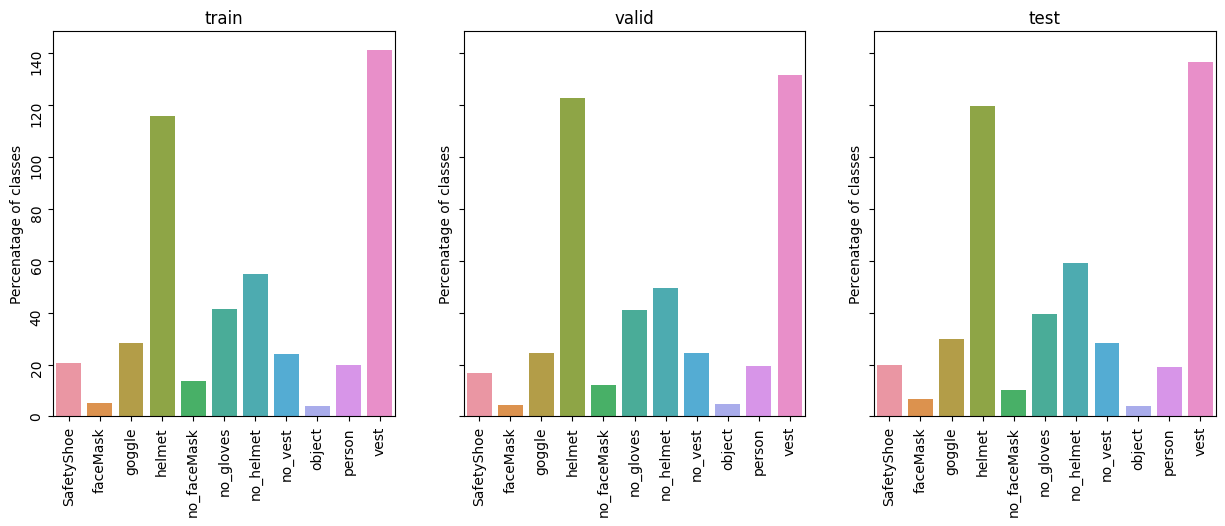

In [25]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(modesArray):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

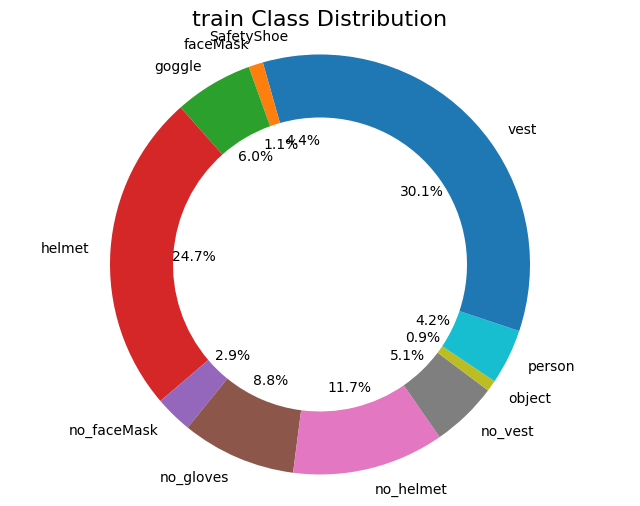

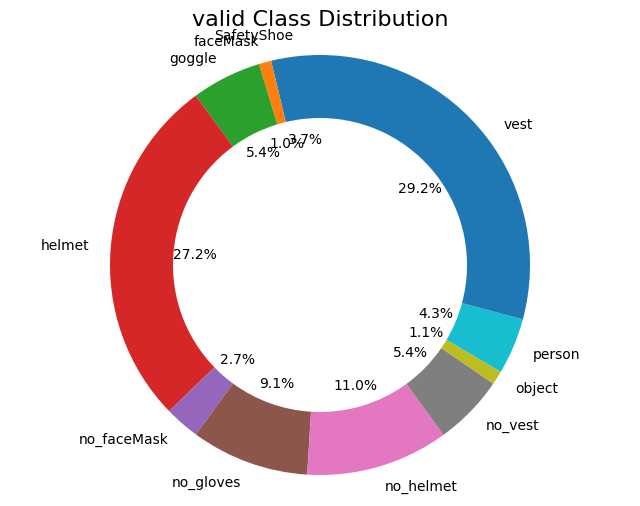

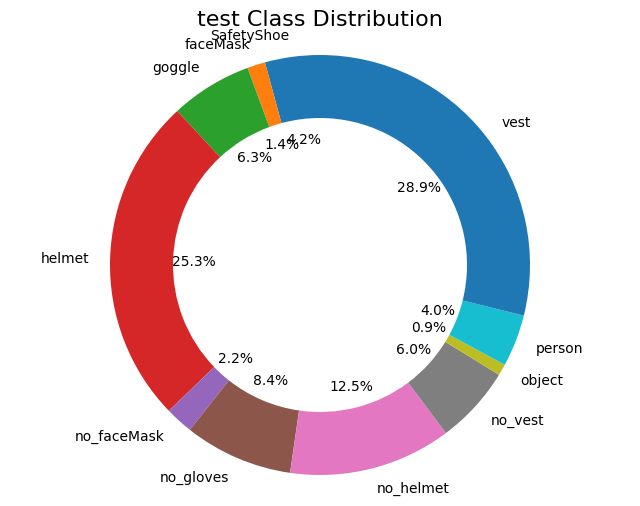

In [26]:
for mode in modesArray:
    plt.figure(figsize=(8, 6))
    plt.pie(class_stat[mode].values(), labels=class_stat[mode].keys(), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
    plt.title(f"{mode} Class Distribution", fontsize=16)
    plt.axis('equal')
    plt.show()


- There is imbalance in classes


- Overall class distribution between train, validation and test sets are similar, although validation and test sets have significantly lower percentage of `machinery` class

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check image sizes</b></h4>

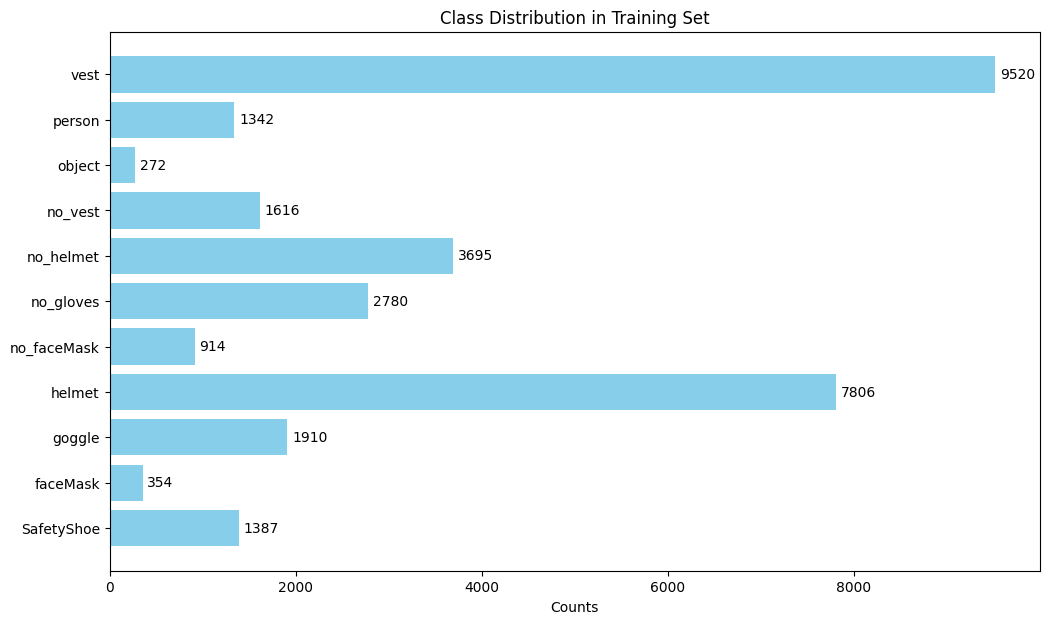

In [51]:
# Data for training set
train_data = {'SafetyShoe': 1387, 'faceMask': 354, 'goggle': 1910, 'helmet': 7806,
              'no_faceMask': 914, 'no_gloves': 2780, 'no_helmet': 3695, 'no_vest': 1616,
              'object': 272, 'person': 1342, 'vest': 9520}

labels = list(train_data.keys())
train_values = list(train_data.values())

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(labels, train_values, color='skyblue')
ax.set_xlabel('Counts')
ax.set_title('Class Distribution in Training Set')

for i, v in enumerate(train_values):
    ax.text(v + 50, i, str(v), color='black', verticalalignment='center')

plt.show()


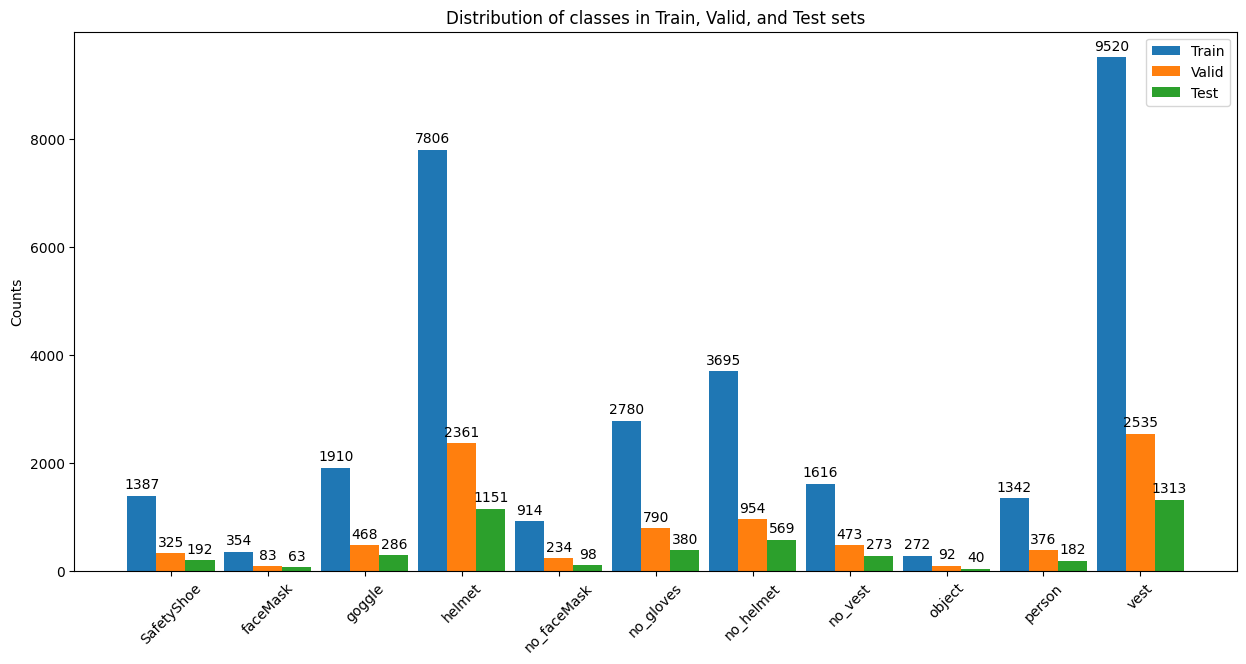

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
train_data = {'SafetyShoe': 1387, 'faceMask': 354, 'goggle': 1910, 'helmet': 7806,
              'no_faceMask': 914, 'no_gloves': 2780, 'no_helmet': 3695, 'no_vest': 1616,
              'object': 272, 'person': 1342, 'vest': 9520}
valid_data = {'SafetyShoe': 325, 'faceMask': 83, 'goggle': 468, 'helmet': 2361,
              'no_faceMask': 234, 'no_gloves': 790, 'no_helmet': 954, 'no_vest': 473,
              'object': 92, 'person': 376, 'vest': 2535}
test_data = {'SafetyShoe': 192, 'faceMask': 63, 'goggle': 286, 'helmet': 1151,
             'no_faceMask': 98, 'no_gloves': 380, 'no_helmet': 569, 'no_vest': 273,
             'object': 40, 'person': 182, 'vest': 1313}

labels = list(train_data.keys())
train_values = list(train_data.values())
valid_values = list(valid_data.values())
test_values = list(test_data.values())

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 7))

rects1 = ax.bar(x - width, train_values, width, label='Train')
rects2 = ax.bar(x, valid_values, width, label='Valid')
rects3 = ax.bar(x + width, test_values, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Distribution of classes in Train, Valid, and Test sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

plt.xticks(rotation=45)
plt.show()


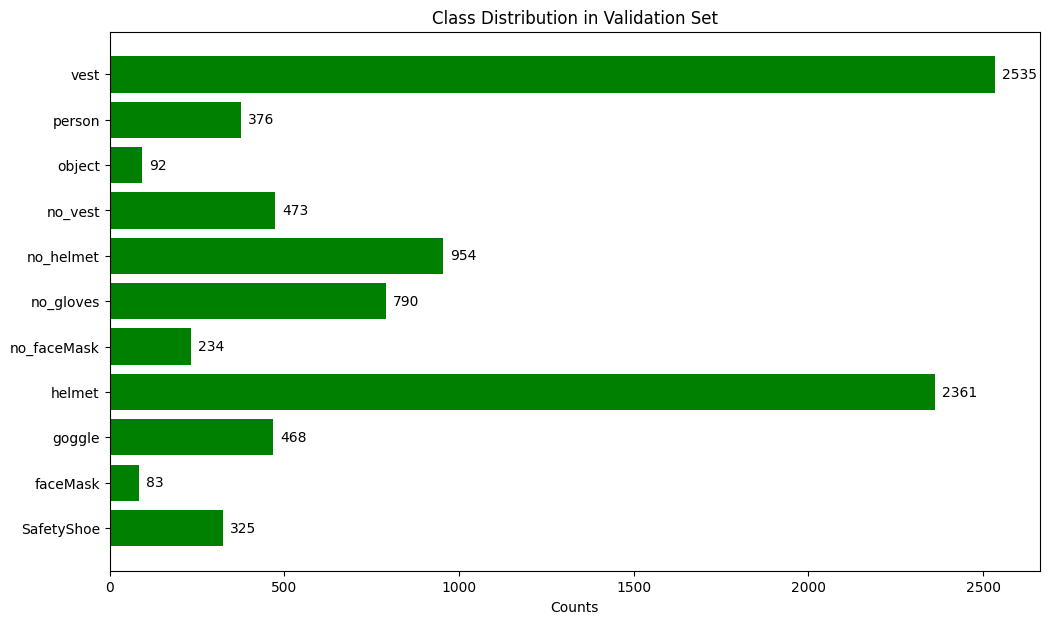

In [53]:
# Data for validation set
valid_data = {'SafetyShoe': 325, 'faceMask': 83, 'goggle': 468, 'helmet': 2361,
              'no_faceMask': 234, 'no_gloves': 790, 'no_helmet': 954, 'no_vest': 473,
              'object': 92, 'person': 376, 'vest': 2535}

labels = list(valid_data.keys())
valid_values = list(valid_data.values())

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(labels, valid_values, color='green')
ax.set_xlabel('Counts')
ax.set_title('Class Distribution in Validation Set')

for i, v in enumerate(valid_values):
    ax.text(v + 20, i, str(v), color='black', verticalalignment='center')

plt.show()


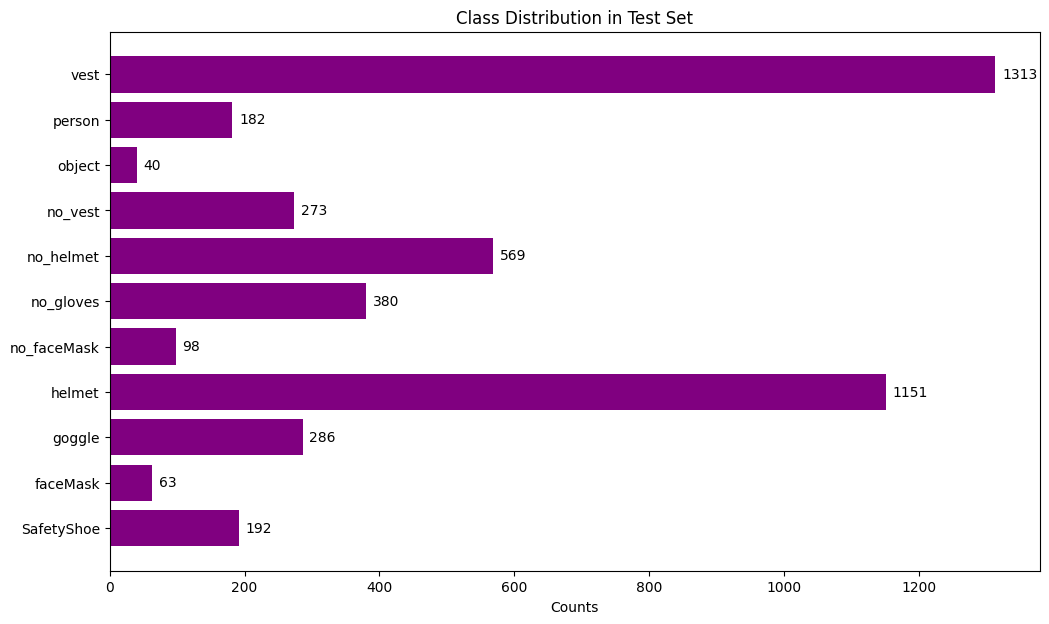

In [54]:
# Data for test set
test_data = {'SafetyShoe': 192, 'faceMask': 63, 'goggle': 286, 'helmet': 1151,
             'no_faceMask': 98, 'no_gloves': 380, 'no_helmet': 569, 'no_vest': 273,
             'object': 40, 'person': 182, 'vest': 1313}

labels = list(test_data.keys())
test_values = list(test_data.values())

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(labels, test_values, color='purple')
ax.set_xlabel('Counts')
ax.set_title('Class Distribution in Test Set')

for i, v in enumerate(test_values):
    ax.text(v + 10, i, str(v), color='black', verticalalignment='center')

plt.show()


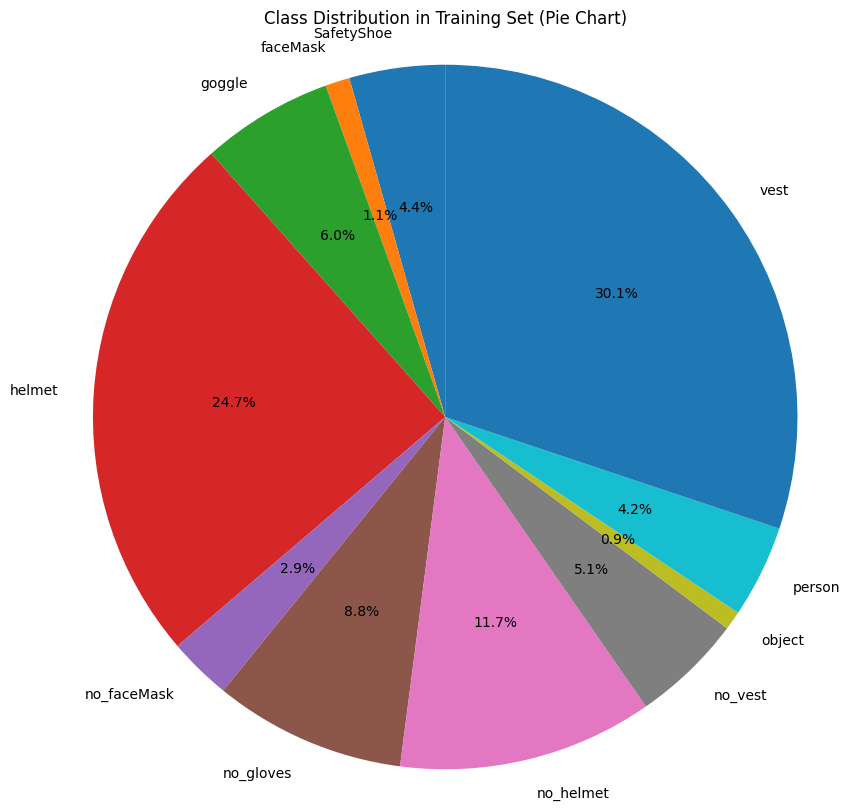

In [55]:
# Data for training set
train_data = {'SafetyShoe': 1387, 'faceMask': 354, 'goggle': 1910, 'helmet': 7806,
              'no_faceMask': 914, 'no_gloves': 2780, 'no_helmet': 3695, 'no_vest': 1616,
              'object': 272, 'person': 1342, 'vest': 9520}

labels = list(train_data.keys())
train_values = list(train_data.values())

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(train_values, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax.set_title('Class Distribution in Training Set (Pie Chart)')
plt.show()


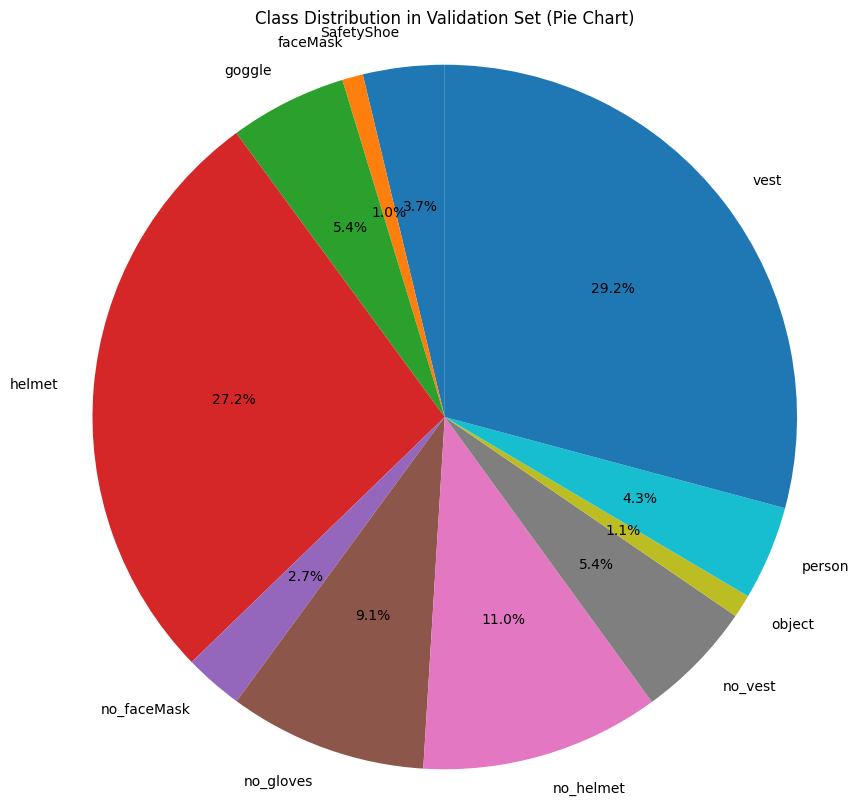

In [56]:
# Data for validation set
valid_data = {'SafetyShoe': 325, 'faceMask': 83, 'goggle': 468, 'helmet': 2361,
              'no_faceMask': 234, 'no_gloves': 790, 'no_helmet': 954, 'no_vest': 473,
              'object': 92, 'person': 376, 'vest': 2535}

labels = list(valid_data.keys())
valid_values = list(valid_data.values())

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(valid_values, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax.set_title('Class Distribution in Validation Set (Pie Chart)')
plt.show()


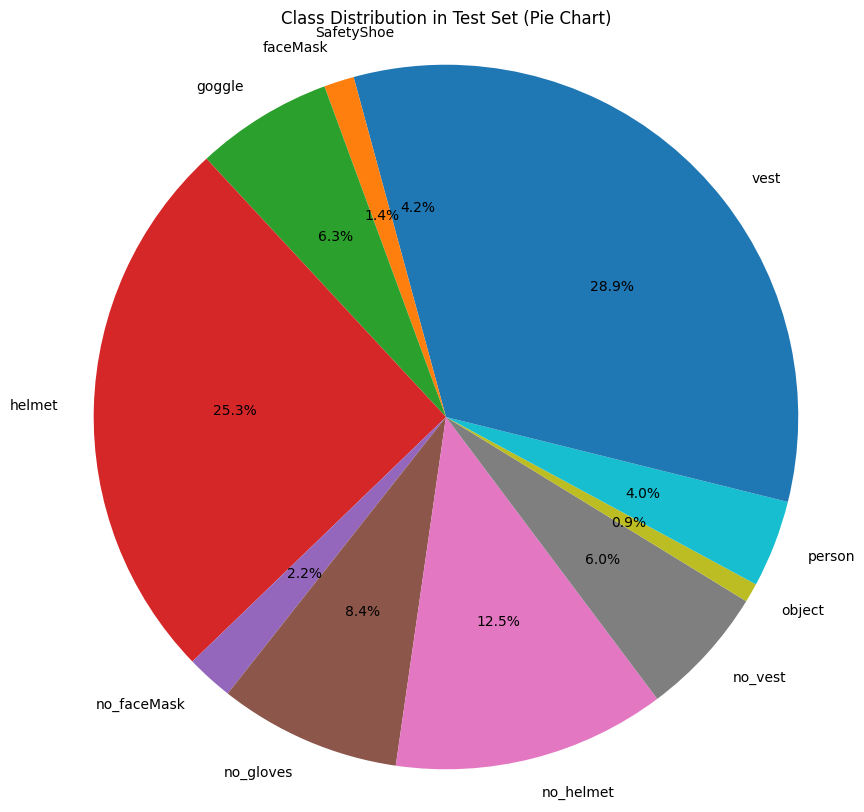

In [57]:
# Data for test set
test_data = {'SafetyShoe': 192, 'faceMask': 63, 'goggle': 286, 'helmet': 1151,
             'no_faceMask': 98, 'no_gloves': 380, 'no_helmet': 569, 'no_vest': 273,
             'object': 40, 'person': 182, 'vest': 1313}

labels = list(test_data.keys())
test_values = list(test_data.values())

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(test_values, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax.set_title('Class Distribution in Test Set (Pie Chart)')
plt.show()


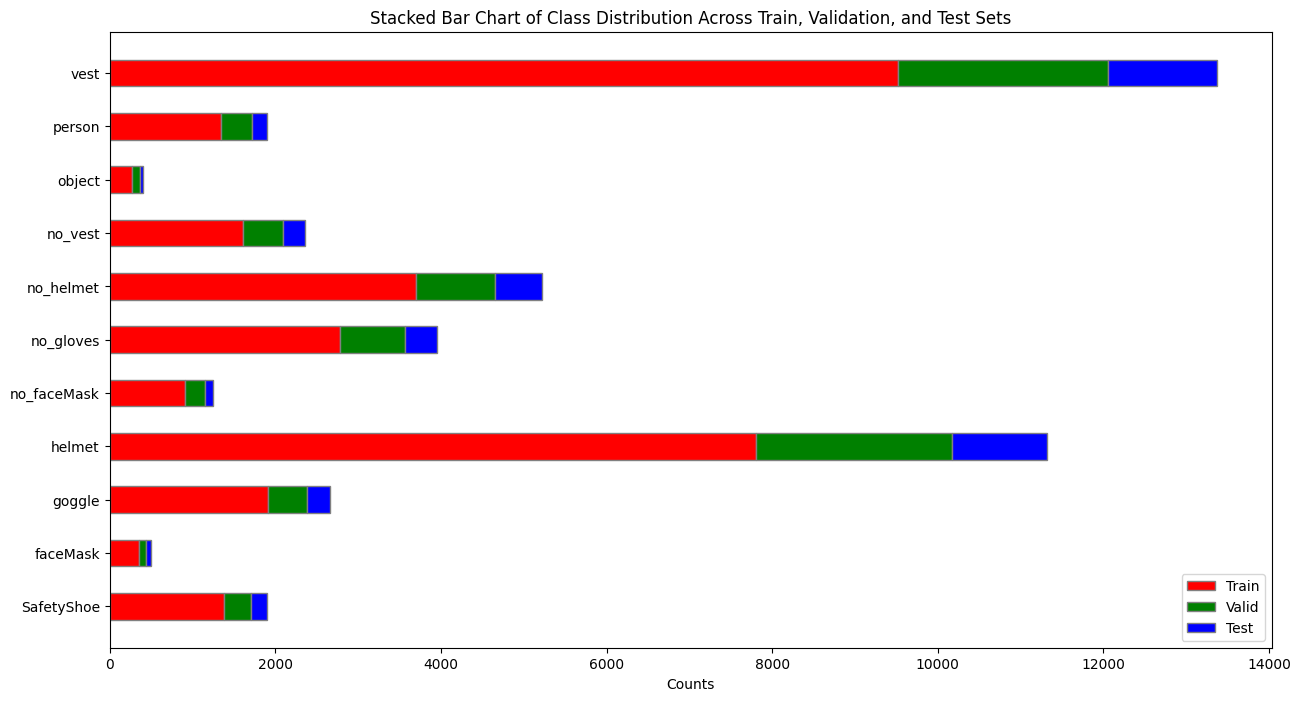

In [58]:
import numpy as np

# Data
labels = list(train_data.keys())
train_values = np.array(list(train_data.values()))
valid_values = np.array(list(valid_data.values()))
test_values = np.array(list(test_data.values()))

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.5

# Stacked Bars
ax.barh(labels, train_values, color='r', edgecolor='grey', height=bar_width, label='Train')
ax.barh(labels, valid_values, left=train_values, color='g', edgecolor='grey', height=bar_width, label='Valid')
ax.barh(labels, test_values, left=train_values+valid_values, color='b', edgecolor='grey', height=bar_width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Counts')
ax.set_title('Stacked Bar Chart of Class Distribution Across Train, Validation, and Test Sets')
ax.legend()

plt.show()


In [28]:
for mode in modesArray:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(DATASET_DIR, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(480, 480)

Image sizes in valid set:

	(480, 480)

Image sizes in test set:

	(480, 480)


- All images have size `480x480`

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check dataset sizes</b></h4>

In [29]:
for mode in modesArray:

    files =  glob.glob(os.path.join(DATASET_DIR, mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')

train set size: 6734

valid set size: 1924

test set size: 962



<a id="train"></a>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Train</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Arguments for training</b></h4>

- **task**: preform `detect`, `segment` or `classify`
- **imgsz**: define input image size
- **batch**: determine batch size
- **epochs**: define the number of training epochs. (Note: often, 3000+ are common here!)
- **data**: set the path to our yaml file
- **mode**: mode - `train`, `val` or `predict`
- **model**: model to use (could be pre-trained)
- **name**: result names

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Load model<b></h4>

- Load `pre-trained` YOLO-nano model

In [42]:
from ultralytics import settings
!wandb login

# Update a setting
#settings.update({'runs_dir': '/path/to/runs'})

# Update multiple settings
#settings.update({'runs_dir': '/path/to/runs', 'tensorboard': False})

# Reset settings to default values
#settings.reset()

# Print
formatted_settings = [f"- {key}: {value}" for key, value in settings.items()]
formatted_output = ',\n'.join(formatted_settings)
print(formatted_output)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
- settings_version: 0.0.4,
- datasets_dir: /content/project/dataset,
- weights_dir: /content/project/weights,
- runs_dir: /content/project/runs,
- uuid: 569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb,
- sync: True,
- api_key: ,
- clearml: True,
- comet: True,
- dvc: True,
- hub: True,
- mlflow: True,
- neptune: True,
- raytune: True,
- tensorboard: True,
- wandb: True


In [43]:
# Modify and Update Setting
# Return a specific setting
#value = settings['runs_dir']
#print(value)
# Update datasets_dir
settings.update({'datasets_dir': DATASET_DIR})
# Update datasets_dir
settings.update({'runs_dir': f'{WORKING_DIR}/runs'})
# Update datasets_dir
settings.update({'weights_dir': f'{WORKING_DIR}/weights'})
# Print
formatted_settings = [f"- {key}: {value}" for key, value in settings.items()]
formatted_output = ',\n'.join(formatted_settings)
print(formatted_output)

- settings_version: 0.0.4,
- datasets_dir: /content/project/dataset,
- weights_dir: /content/project/weights,
- runs_dir: /content/project/runs,
- uuid: 569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb,
- sync: True,
- api_key: ,
- clearml: True,
- comet: True,
- dvc: True,
- hub: True,
- mlflow: True,
- neptune: True,
- raytune: True,
- tensorboard: True,
- wandb: True


In [44]:
model = YOLO('yolov8n.pt')

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Train</b></h4>

In [45]:
#model.train(data=YAML_PATH,
#            task='detect',
#            imgsz=480,
#            epochs=50,
#            batch=32,
#            mode='train',
#            plots=True,
#            resume=True,
#            save=True,
#            patience=50,
#            save_period=1,
#            name='yolov8n_v2_train')

model.train(data=YAML_PATH,
            task='detect',
            imgsz=480,
            epochs=NUMB_TRN_EPOCHS,
            save=True,
            patience=50,
            batch=32,
            save_period=1,
            mode='train',
            name=YOLO_MODEL_NAME)


Ultralytics YOLOv8.0.181 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/project/data.yaml, epochs=10, patience=50, batch=32, imgsz=480, save=True, save_period=1, cache=False, device=None, workers=8, project=None, name=yolov8n_v1_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, op

KeyboardInterrupt: ignored

In [ ]:
#pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu111/torch_stable.html


In [ ]:
#import torch
#print(torch.cuda.is_available())


<a id="test"></a>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Test</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Select best model</b></h4>

In [ ]:
model = YOLO('runs/detect/yolov8n_v1_train/weights/best.pt')

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Make predicitons on test set</b></h4>

In [ ]:
results = model.predict(source=os.path.join(INPUT_DIR, 'test', 'images'), save=True)

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Show prediction results</b></h4>

In [ ]:
%matplotlib inline

predicitions = glob.glob(os.path.join(WORK_DIR, 'runs/detect/predict2', '*'))

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()